In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
#from skimage.filters import gaussian
#from skimage.filters import threshold_otsu
#from skimage.morphology import binary_erosion
#from skimage.morphology import remove_small_objects, label
#from skimage.measure import regionprops
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.color import rgb2gray
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv

In [9]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

In [10]:
#PNG Direct Import
#file = plt.imread('./PristineZoom/20230126_KPN005_00006.png')[:,:,:3]

#IgrayI = rgb2gray(file)
#plt.imshow(IgrayI)



In [12]:
    #Zoom
file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
#plt.imshow(image_raw)

[Sun, 02 Apr 2023 11:25:44] [INFO    ] [topostats] Extracting image from PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sun, 02 Apr 2023 11:25:44] [INFO    ] [topostats] Loading image from : PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sun, 02 Apr 2023 11:25:44] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Loaded image from : PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sun, 02 Apr 2023 11:25:45] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Extracted channel Height
[Sun, 02 Apr 2023 11:25:45] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Pixel to nm scaling : 2.1866406250000003


In [13]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sun, 02 Apr 2023 11:25:47] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Median flattening without mask
[Sun, 02 Apr 2023 11:25:47] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Plane tilt removal without mask
[Sun, 02 Apr 2023 11:25:48] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : x-polyfit 1st order: [-0.01373336  6.99787912]
[Sun, 02 Apr 2023 11:25:48] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : y-polyfit 1st order: [-8.02035087e-20  1.79801973e-16]
[Sun, 02 Apr 2023 11:25:48] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Removing x plane tilt
[Sun, 02 Apr 2023 11:25:49] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : removing y plane tilt
[Sun, 02 Apr 2023 11:25:51] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0

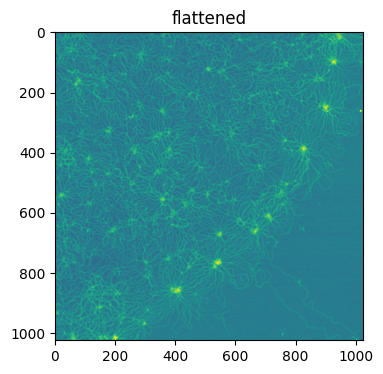

thresholds: defaultdict(None, {'upper': 0.459990175697773})
[Sun, 02 Apr 2023 12:00:28] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.459990175697773


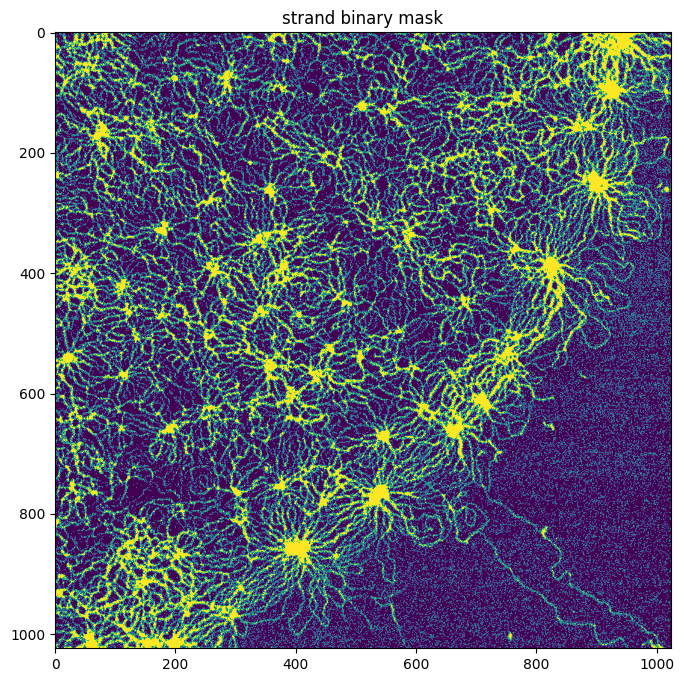

In [52]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

strand_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 0.5, 'lower': None}
)

print(f'thresholds: {strand_thresholds}')
strand_mask = topofilters.get_mask(image=flattened, thresholds=strand_thresholds)
plot(strand_mask.astype(bool), title='strand binary mask', zlimit=False)

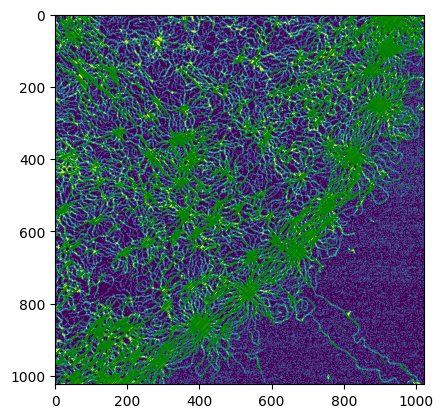

<Figure size 640x480 with 0 Axes>

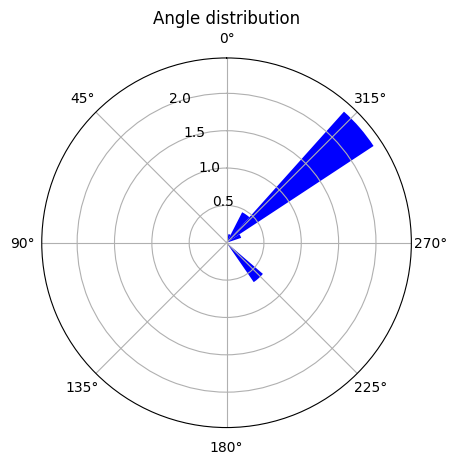

In [55]:
H, theta, rho = hough_line(strand_mask)
P = hough_line_peaks(H, theta, rho, threshold=0.5 * np.max(H), num_peaks=300)

# the transform probabilistic_hough_line function defines how to draw the lines. The numbers were optimized using the set of images available.
lines = probabilistic_hough_line(strand_mask, threshold=int(0.5*np.max(H)), line_length=15, line_gap=3)

# Plot the lines on top of image marking the beginning and end
plt.imshow(strand_mask)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), 'g-', linewidth=0.5)

# To be able to plot the angles using the plt.polar function, it is necessary to transform all the degree values of theta to radians using np.deg2rad.
plt.figure()
angles = []
for line in lines:
    p0, p1 = line
    theta = np.arctan2(p1[1] - p0[1], p1[0] - p0[0])
    angles.append(theta)
plt.figure()
ax = plt.subplot(111, projection='polar')
ax.hist(angles, bins=24, color='blue', density=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(1)
plt.title('Angle distribution')
plt.show()
